# TweetyCLR 

## Loading Libraries and Creating Objects

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns 
import umap
import os 
from bokeh.plotting import figure, show, output_file, save
from bokeh.models import HoverTool, ColumnDataSource
import seaborn as sns
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import DataLoader, TensorDataset
from statistics import mode
from collections import defaultdict
import random
import sys
import warnings 
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
sys.path.append('/home/akapoor/MNIST_Classification_Models/')

from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from util import EarlyStopping, MetricMonitor
from util import TwoCropTransform, SupCon, SupConLoss, save_model

sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})


In [2]:
class Tweetyclr:
    def __init__(self, num_spec, window_size, stride, folder_name, all_songs_data, masking_freq_tuple, spec_dim_tuple, exclude_transitions = False, category_colors = None):
        '''The init function should define:
            1. directory for bird
            2. directory for python files
            3. analysis path
            4. folder name 


            Additional tasks
            1. create the folder name if it does not exist already

        '''
        # self.bird_dir = bird_dir
        # self.directory = directory
        self.num_spec = num_spec
        self.window_size = window_size
        self.stride = stride
        # self.analysis_path = analysis_path
        self.category_colors = category_colors
        self.folder_name = folder_name
        self.all_songs_data = all_songs_data
        self.masking_freq_tuple = masking_freq_tuple
        self.freq_dim = spec_dim_tuple[1]
        self.time_dim = spec_dim_tuple[0]
        self.exclude_transitions = exclude_transitions

        # Create the folder if it doesn't already exist
        if not os.path.exists(folder_name+"/Plots/Window_Plots"):
            os.makedirs(folder_name+"/Plots/Window_Plots")
            print(f'Folder "{folder_name}" created successfully.')
        else:
            print(f'Folder "{folder_name}" already exists.')

    def first_time_analysis(self):

        # For each spectrogram we will extract
        # 1. Each timepoint's syllable label
        # 2. The spectrogram itself
        stacked_labels = [] 
        stacked_specs = []
        for i in np.arange(self.num_spec):
            # Extract the data within the numpy file. We will use this to create the spectrogram
            dat = np.load(self.all_songs_data[i])
            spec = dat['s']
            times = dat['t']
            frequencies = dat['f']
            labels = dat['labels']
            labels = labels.T


            # Let's get rid of higher order frequencies
            mask = (frequencies<self.masking_freq_tuple[1])&(frequencies>self.masking_freq_tuple[0])
            masked_frequencies = frequencies[mask]

            subsetted_spec = spec[mask.reshape(mask.shape[0],),:]
            
            stacked_labels.append(labels)
            stacked_specs.append(subsetted_spec)

            
        stacked_specs = np.concatenate((stacked_specs), axis = 1)
        stacked_labels = np.concatenate((stacked_labels), axis = 0)
        stacked_labels.shape = (stacked_labels.shape[0],1)


        # Get a list of unique categories (syllable labels)
        unique_categories = np.unique(stacked_labels)
        if self.category_colors == None:
            self.category_colors = {category: np.random.rand(3,) for category in unique_categories}
            self.category_colors[0] = np.zeros((3)) # SIlence should be black
            # open a file for writing in binary mode
            with open(f'{self.folder_name}/category_colors.pkl', 'wb') as f:
                # write the dictionary to the file using pickle.dump()
                pickle.dump(self.category_colors, f)

        spec_for_analysis = stacked_specs.T
        window_labels_arr = []
        embedding_arr = []
        # Find the exact sampling frequency (the time in miliseconds between one pixel [timepoint] and another pixel)
        print(times.shape)
        dx = np.diff(times)[0,0]

        # We will now extract each mini-spectrogram from the full spectrogram
        stacked_windows = []
        # Find the syllable labels for each mini-spectrogram
        stacked_labels_for_window = []
        # Find the mini-spectrograms onset and ending times 
        stacked_window_times = []

        # The below for-loop will find each mini-spectrogram (window) and populate the empty lists we defined above.
        for i in range(0, spec_for_analysis.shape[0] - self.window_size + 1, self.stride):
            # Find the window
            window = spec_for_analysis[i:i + self.window_size, :]
            # Get the window onset and ending times
            window_times = dx*np.arange(i, i + self.window_size)
            # We will flatten the window to be a 1D vector
            window = window.reshape(1, window.shape[0]*window.shape[1])
            # Extract the syllable labels for the window
            labels_for_window = stacked_labels[i:i+self.window_size, :]
            # Reshape the syllable labels for the window into a 1D array
            labels_for_window = labels_for_window.reshape(1, labels_for_window.shape[0]*labels_for_window.shape[1])
            # Populate the empty lists defined above
            stacked_windows.append(window)
            stacked_labels_for_window.append(labels_for_window)
            stacked_window_times.append(window_times)

        # Convert the populated lists into a stacked numpy array
        stacked_windows = np.stack(stacked_windows, axis = 0)
        stacked_windows = np.squeeze(stacked_windows)

        stacked_labels_for_window = np.stack(stacked_labels_for_window, axis = 0)
        stacked_labels_for_window = np.squeeze(stacked_labels_for_window)

        stacked_window_times = np.stack(stacked_window_times, axis = 0)
        dict_of_spec_slices_with_slice_number = {i: stacked_windows[i, :] for i in range(stacked_windows.shape[0])}

        # For each mini-spectrogram, find the average color across all unique syllables
        mean_colors_per_minispec = np.zeros((stacked_labels_for_window.shape[0], 3))
        for i in np.arange(stacked_labels_for_window.shape[0]):
            list_of_colors_for_row = [self.category_colors[x] for x in stacked_labels_for_window[i,:]]
            all_colors_in_minispec = np.array(list_of_colors_for_row)
            mean_color = np.mean(all_colors_in_minispec, axis = 0)
            mean_colors_per_minispec[i,:] = mean_color

        self.stacked_windows = stacked_windows
        self.stacked_labels_for_window = stacked_labels_for_window
        self.mean_colors_per_minispec = mean_colors_per_minispec
        self.stacked_window_times = stacked_window_times
        self.masked_frequencies = masked_frequencies
        self.dict_of_spec_slices_with_slice_number = dict_of_spec_slices_with_slice_number

    def z_score(self, data):

        # Compute the mean and standard deviation
        mean = np.mean(data, axis=1, keepdims=True)
        std_dev = np.std(data, axis=1, keepdims=True)
    
        # Avoid division by zero by setting zero std_devs to 1 (this won't change the data)
        # std_dev[std_dev == 0] = 1
    
        # Z-score the matrix
        data -= mean
        data /= std_dev
        
        # Replace any NaN values
        data[np.isnan(data)] = 0 
        
        return data



    def embeddable_image(self, data, folderpath_for_slices, window_times, iteration_number):
        # This function will save an image for each mini-spectrogram. This will be used for understanding the UMAP plot.

    
        data.shape = (self.window_size, int(data.shape[0]/self.window_size))
        data = data.T 
        window_times = window_times.reshape(1, window_times.shape[0])
        plt.pcolormesh(window_times, self.masked_frequencies, data, cmap='jet')
        # let's save the plt colormesh as an image.
        plt.savefig(f'{folderpath_for_slices}/Window_{iteration_number}.png')
        plt.close()


    def compute_UMAP_decomp(self, zscored):
        # Perform a UMAP embedding on the dataset of mini-spectrograms
        reducer = umap.UMAP()
        embedding = reducer.fit_transform(zscored)

        return embedding

    def plot_UMAP_embedding(self, embedding, mean_colors_per_minispec, filepath_name, saveflag = False):

        # Specify an HTML file to save the Bokeh image to.
        # output_file(filename=f'{self.folder_name}Plots/{filename_val}.html')
        output_file(filename = f'{self.folder_name}Plots/{filepath_name}.html')

        # Convert the UMAP embedding to a Pandas Dataframe
        spec_df = pd.DataFrame(embedding, columns=('x', 'y'))


        # Create a ColumnDataSource from the data. This contains the UMAP embedding components and the mean colors per mini-spectrogram
        source = ColumnDataSource(data=dict(x = embedding[:,0], y = embedding[:,1], colors=mean_colors_per_minispec))


        # Create a figure and add a scatter plot
        p = figure(width=800, height=600, tools=('pan, box_zoom, hover, reset'))
        p.scatter(x='x', y='y', size = 7, color = 'colors', source=source)

        hover = p.select(dict(type=HoverTool))
        hover.tooltips = """
            <div>
                <h3>@x, @y</h3>
                <div>
                    <img
                        src="@image" height="100" alt="@image" width="100"
                        style="float: left; margin: 0px 15px 15px 0px;"
                        border="2"
                    ></img>
                </div>
            </div>
        """

        p.add_tools(HoverTool(tooltips="""
        """))


        save(p)
        show(p)

    def find_slice_actual_labels(self, stacked_labels_for_window):
        al = []
        for i in np.arange(stacked_labels_for_window.shape[0]):
            arr = stacked_labels_for_window[i,:]
            unique_elements, counts = np.unique(arr, return_counts=True)
            # print(unique_elements)
            # print(counts)
            sorted_indices = np.argsort(-counts)
            val = unique_elements[sorted_indices[0]]
            if val == 0:
                if unique_elements.shape[0]>1:
                    val = unique_elements[sorted_indices[1]]
            al.append(val)

        actual_labels = np.array(al)
        
        self.actual_labels = actual_labels

    def shuffling(self, shuffled_indices = None):
        
        if shuffled_indices is None:
            shuffled_indices = np.random.permutation(self.stacked_windows.shape[0])
                    
        self.shuffled_indices = shuffled_indices
        
        
    def train_test_split(self, train_split_perc, batch_size, dataset, shuffled_indices):
        ''' 
        The following is the procedure I want to do for the train_test_split.
        '''
        
        # I want to make training indices to be the first 80% of the shuffled data
        # split_point = int(train_split_perc*dataset.shape[0])
        
        # Number of starting points needed
        num_starts = -(-dataset.shape[0] // 3)  # Ceiling division
        
        # Sample every k-th index from the shuffled array until we reach the desired number of base indices. THese indices are w.r.t. the original array ordering
        anchor_indices = shuffled_indices[::3][:num_starts]
        # For each base index, add index + 1 and index + 2 to the training set
        training_indices = []
        for idx in anchor_indices:
            training_indices.extend([idx, idx + 1, idx + 2])
        
        # Trim in case we got more than desired due to rounding
        # training_indices = training_indices[:split_point]
        
        
        # Shuffle array1 using the shuffled indices
        self.stacked_windows_for_analysis_modeling = self.stacked_windows[shuffled_indices,:]
        # Shuffle array2 using the same shuffled indices
        self.stacked_labels_for_analysis_modeling= self.stacked_labels_for_window[shuffled_indices,:]
        self.mean_colors_per_minispec_for_analysis_modeling = self.mean_colors_per_minispec[shuffled_indices, :]
        
        
        
        
        stacked_windows_train = torch.tensor(self.stacked_windows[anchor_indices,:])
        self.stacked_windows_train = stacked_windows_train.reshape(stacked_windows_train.shape[0], 1, self.time_dim, self.freq_dim)
        self.anchor_indices = anchor_indices
        self.train_indices = np.array(training_indices)
        
        self.mean_colors_per_minispec_train = self.mean_colors_per_minispec[anchor_indices,:]
        self.stacked_labels_train = self.stacked_labels_for_window[anchor_indices,:]
        
        
        self.anchor_train_indices = anchor_indices



In [3]:
def pretraining(epoch, model, contrastive_loader, optimizer, criterion, method='SimCLR'):
    "Contrastive pre-training over an epoch"
    negative_similarities_for_epoch = []
    ntxent_positive_similarities_for_epoch = []
    mean_pos_cos_sim_for_epoch = []
    mean_ntxent_positive_similarities_for_epoch = []
    metric_monitor = MetricMonitor()
    model.train()
    for batch_idx, ((data1, labels1), (data2, labels2)) in enumerate(contrastive_loader):
        data = torch.cat((data1,data2), dim = 0)
        labels = labels1
        if torch.cuda.is_available():
            data,labels = data.cuda(), labels.cuda()
        data, labels = torch.autograd.Variable(data,False), torch.autograd.Variable(labels)
        bsz = labels.shape[0]
        data = data.to(torch.float32)
        features = model(data)
        norm = features.norm(p=2, dim=1, keepdim=True)
        epsilon = 1e-12
        # Add a small epsilon to prevent division by zero
        normalized_tensor = features / (norm + epsilon)
        f1, f2 = torch.split(normalized_tensor, [bsz, bsz], dim=0)
        features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)
        if method == 'SupCon':
            loss, negative_similarities, positive_similarities = criterion(features, labels)
        elif method == 'SimCLR':
            loss, negative_similarities, positive_similarities = criterion(features)
        else:
            raise ValueError('contrastive method not supported: {}'.format(method))
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Learning Rate", optimizer.param_groups[0]['lr'])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        negative_similarities_for_epoch.append(float(np.mean(negative_similarities.clone().detach().cpu().numpy())))

        ntxent_positive_similarities_for_epoch.append(positive_similarities)
        
        # # Calculate the mean cosine similarity of the model feature representation for the positive pairs.
        # # Slice the tensor to separate the two sets of features you want to compare
        f1, f2 = torch.split(normalized_tensor, [bsz, bsz], dim=0)
        normalized_features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)
        
        tensor_a = normalized_features[:, 0, :].clone().detach()
        tensor_b = normalized_features[:, 1, :].clone().detach()
        
        # Compute the cosine similarities
        similarities = F.cosine_similarity(tensor_a, tensor_b, dim=1)
        mean_pos_cos_sim_for_batch = torch.mean(similarities).clone().detach().cpu().numpy()
        mean_ntxent_positive_similarities = torch.mean(positive_similarities).clone().detach().cpu().numpy()
        mean_ntxent_positive_similarities_for_epoch.append(float(mean_ntxent_positive_similarities))
        mean_pos_cos_sim_for_epoch.append(float(mean_pos_cos_sim_for_batch))

    print("[Epoch: {epoch:03d}] Contrastive Pre-train | {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor))
    return metric_monitor.metrics['Loss']['avg'], metric_monitor.metrics['Learning Rate']['avg'], negative_similarities_for_epoch, features, mean_pos_cos_sim_for_epoch, mean_ntxent_positive_similarities_for_epoch


In [4]:
class Temporal_Augmentation:
    
    def __init__(self, total_dict, simple_tweetyclr):
        self.total_dict = total_dict
        self.tweetyclr_obj = simple_tweetyclr
    
    def __call__(self, x):
        batch_data = x[0]
        indices = x[1]
    
        # Preallocate tensors with the same shape as batch_data
        positive_aug_1 = torch.empty_like(batch_data)
        positive_aug_2 = torch.empty_like(batch_data)
        
        total_training_indices = list(self.total_dict.keys())
        
        positive_aug_1_indices = indices + 1
        positive_aug_2_indices = indices + 2
        
        if np.sort(total_training_indices)[-2] in indices:
            # index_of_value = int(torch.where(indices == total_training_indices[-2])[0])
            # positive_aug_2_indices = indices.unsqueeze(0)[index_of_value]-1
            positive_aug_2_indices = int(indices)-1
        elif np.sort(total_training_indices)[-1] in indices:
            # index_of_value = int(torch.where(indices == total_training_indices[-1])[0])
            positive_aug_1_indices = int(indices)-2
            positive_aug_2_indices = int(indices)-1
            
        try:
            # Your code that might raise the exception
            positive_aug_1 = torch.tensor(self.total_dict[int(positive_aug_1_indices)].reshape(batch_data.shape[0], 1, self.tweetyclr_obj.time_dim, self.tweetyclr_obj.freq_dim))
            positive_aug_2 = torch.tensor(self.total_dict[int(positive_aug_2_indices)].reshape(batch_data.shape[0], 1, self.tweetyclr_obj.time_dim, self.tweetyclr_obj.freq_dim))
        
        except ValueError as e:
            print(f"Encountered KeyError: {e}. Press Enter to continue...")
            input()
            

        return positive_aug_1, positive_aug_2

class New_Method_CustomContrastiveDataset(Dataset):
    def __init__(self, tensor_data, tensor_labels, transform=None):
        self.data = tensor_data
        self.labels = tensor_labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        lab = self.labels[index]
        x = [x,lab]
        x1 = self.transform(x) if self.transform else x

        return [x1, lab]


class TwoCropTransform:
    """Create two crops of the same image"""
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, x):
        # Get the two augmentations from jawn
        aug1, aug2 = self.transform(x)
        return [aug1, aug2]


In [5]:
num_epochs = 200
device = 'cuda'
class TweetyNetCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3,1,padding=1) 
        self.conv2 = nn.Conv2d(8, 8, 3,2,padding=1) 
        self.conv3 = nn.Conv2d(8, 16,3,1,padding=1) 
        self.conv4 = nn.Conv2d(16,16,3,2,padding=1) 
        self.conv5 = nn.Conv2d(16,24,3,1,padding=1) 
        self.conv6 = nn.Conv2d(24,24,3,2,padding=1) 
        self.conv7 = nn.Conv2d(24,32,3,1,padding=1) 
        self.conv8 = nn.Conv2d(32,24,3,2,padding=1)
        self.conv9 = nn.Conv2d(24,24,3,1,padding=1)
        self.conv10 = nn.Conv2d(24,16,3,2,padding=1)
        
        
        self.bn1 = nn.BatchNorm2d(1) 
        self.bn2 = nn.BatchNorm2d(8) 
        self.bn3 = nn.BatchNorm2d(8) 
        self.bn4 = nn.BatchNorm2d(16) 
        self.bn5 = nn.BatchNorm2d(16) 
        self.bn6 = nn.BatchNorm2d(24) 
        self.bn7 = nn.BatchNorm2d(24)
        self.bn8 = nn.BatchNorm2d(32)
        self.bn9 = nn.BatchNorm2d(24)
        self.bn10 = nn.BatchNorm2d(24)

        self.relu = nn.ReLU()       
        self.dropout = nn.Dropout2d()
        self._to_linear = 1280
        # self._to_linear = 320
        
    def forward(self, x):
         
        x = F.relu(self.dropout(self.conv1(self.bn1(x))))
        x = F.relu(self.conv2(self.bn2(x))) 
        x = F.relu(self.dropout(self.conv3(self.bn3(x))))
        x = F.relu(self.conv4(self.bn4(x))) 
        x = F.relu(self.dropout(self.conv5(self.bn5(x))))
        x = F.relu(self.conv6(self.bn6(x))) 
        x = F.relu(self.dropout(self.conv7(self.bn7(x))))
        x = F.relu(self.conv8(self.bn8(x)))
        x = F.relu(self.dropout(self.conv9(self.bn9(x))))
        x = F.relu(self.conv10(self.bn10(x)))
        
        # x = F.relu(self.conv1(self.bn1(x)))
        # x = F.relu(self.conv2(self.bn2(x))) 
        # x = F.relu(self.conv3(self.bn3(x)))
        # x = F.relu(self.conv4(self.bn4(x))) 
        # x = F.relu(self.conv5(self.bn5(x)))
        # x = F.relu(self.conv6(self.bn6(x))) 
        # x = F.relu(self.conv7(self.bn7(x)))
        # x = F.relu(self.conv8(self.bn8(x)))
        # x = F.relu(self.conv9(self.bn9(x)))
        # x = F.relu(self.conv10(self.bn10(x)))
        
        # x = x.view(-1, 320)
        x = x.view(-1, 1280) #Window size = 500
        
        return x


## Model 1: Synthetic Dataset

### Model 1.1: Window Size = 100

In [6]:
# Parameters we set
num_spec = 5
window_size = 100
stride = 10


phrase_repeats = 5
num_songs = 25
radius_value = 0.01
num_syllables = 10

folderpath = '/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/'
songpath = f'{folderpath}num_songs_{num_songs}_num_syllables_{num_syllables}_phrase_repeats_{phrase_repeats}_radius_{radius_value}/'
spec_path = f'{songpath}Num_Spectrograms_{num_spec}_Window_Size_{window_size}_Stride_{stride}/'


# # # Load in the category colors that we ran for the real canary data 
# with open('/home/akapoor/Downloads/category_colors.pkl', 'rb') as f:
#     # load the dictionary from the file using pickle.load()
#     category_colors = pickle.load(f)  

folder_name = spec_path

all_songs_data = [element for element in os.listdir(songpath)  if 'Song' in element] 
all_songs_data.sort()
all_songs_data = [f'{songpath}{element}' for element in all_songs_data]

all_songs_data_synthetic = []
for i in np.arange(len(all_songs_data)):
    # os.chdir(all_songs_data[i])
    files = os.listdir(all_songs_data[i])
    all_songs_data_synthetic.append([f'{all_songs_data[i]}/{element}' for element in files if 'synthetic_data.npz' in element]) # Get the file paths of each numpy file from Yarden's data 

all_songs_data_synthetic = [item for sublist in all_songs_data_synthetic for item in (sublist if isinstance(sublist, list) else [sublist])]

masking_freq_tuple = (0, 13090)
spec_dim_tuple = (window_size, 151)


# with open('/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/Num_Spectrograms_60_Window_Size_200_Stride_10/category_colors.pkl', 'rb') as file:
#     category_colors = pickle.load(file)

exclude_transitions = False
all_songs_data = all_songs_data_synthetic

#### Model 1.1.1: Window Size = 100, No Dropout, No weight decay, Temperature = 0.02

Question: How does a low temperature value affect the segmentation ability of our model? 

In [7]:
with open('/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/num_songs_25_num_syllables_10_phrase_repeats_5_radius_0.01/Num_Spectrograms_5_Window_Size_100_Stride_10/category_colors.pkl', 'rb') as file:
    category_colors = pickle.load(file)

simple_tweetyclr_experiment_1 = Tweetyclr(num_spec, window_size, stride, folder_name, all_songs_data, masking_freq_tuple, spec_dim_tuple, exclude_transitions, category_colors = None)
simple_tweetyclr_experiment_1.temperature_value = 0.02
simple_tweetyclr = simple_tweetyclr_experiment_1

Folder "/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/num_songs_25_num_syllables_10_phrase_repeats_5_radius_0.01/Num_Spectrograms_5_Window_Size_100_Stride_10/" created successfully.


#### Model 1.1.2: Window Size = 100, No Dropout, No weight decay, Temperature = 0.07

Question: How does a low temperature value affect the segmentation ability of our model? 

In [7]:
with open('/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/num_songs_25_num_syllables_10_phrase_repeats_5_radius_0.01/Num_Spectrograms_5_Window_Size_100_Stride_10/category_colors.pkl', 'rb') as file:
    category_colors = pickle.load(file)

simple_tweetyclr_experiment_2 = Tweetyclr(num_spec, window_size, stride, folder_name, all_songs_data, masking_freq_tuple, spec_dim_tuple, exclude_transitions, category_colors = category_colors)
simple_tweetyclr_experiment_2.temperature_value = 0.07
simple_tweetyclr = simple_tweetyclr_experiment_2

Folder "/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/num_songs_25_num_syllables_10_phrase_repeats_5_radius_0.01/Num_Spectrograms_5_Window_Size_100_Stride_10/" already exists.


#### Model 1.1.3: Window Size = 100, No Dropout, No weight decay, Temperature = 0.5

Question: How does a low temperature value affect the segmentation ability of our model? 

In [7]:
with open('/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/num_songs_25_num_syllables_10_phrase_repeats_5_radius_0.01/Num_Spectrograms_5_Window_Size_100_Stride_10/category_colors.pkl', 'rb') as file:
    category_colors = pickle.load(file)

simple_tweetyclr_experiment_3 = Tweetyclr(num_spec, window_size, stride, folder_name, all_songs_data, masking_freq_tuple, spec_dim_tuple, exclude_transitions, category_colors = category_colors)
simple_tweetyclr_experiment_3.temperature_value = 0.5
simple_tweetyclr = simple_tweetyclr_experiment_3

Folder "/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/num_songs_25_num_syllables_10_phrase_repeats_5_radius_0.01/Num_Spectrograms_5_Window_Size_100_Stride_10/" already exists.


#### Model 1.1.4: Window Size = 100, No Dropout, No weight decay, Temperature = 1.0

Question: How does a low temperature value affect the segmentation ability of our model? 

In [7]:
with open('/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/num_songs_25_num_syllables_10_phrase_repeats_5_radius_0.01/Num_Spectrograms_5_Window_Size_100_Stride_10/category_colors.pkl', 'rb') as file:
    category_colors = pickle.load(file)

simple_tweetyclr_experiment_4 = Tweetyclr(num_spec, window_size, stride, folder_name, all_songs_data, masking_freq_tuple, spec_dim_tuple, exclude_transitions, category_colors = category_colors)
simple_tweetyclr_experiment_4.temperature_value = 1.0
simple_tweetyclr = simple_tweetyclr_experiment_4

Folder "/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/num_songs_25_num_syllables_10_phrase_repeats_5_radius_0.01/Num_Spectrograms_5_Window_Size_100_Stride_10/" already exists.


#### Model 1.1.5: Window Size = 100, No Dropout, No weight decay, Temperature = 2.0

Question: How does a low temperature value affect the segmentation ability of our model? 

In [7]:
with open('/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/num_songs_25_num_syllables_10_phrase_repeats_5_radius_0.01/Num_Spectrograms_5_Window_Size_100_Stride_10/category_colors.pkl', 'rb') as file:
    category_colors = pickle.load(file)

simple_tweetyclr_experiment_5 = Tweetyclr(num_spec, window_size, stride, folder_name, all_songs_data, masking_freq_tuple, spec_dim_tuple, exclude_transitions, category_colors = category_colors)
simple_tweetyclr_experiment_5.temperature_value = 2.0
simple_tweetyclr = simple_tweetyclr_experiment_5

Folder "/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/num_songs_25_num_syllables_10_phrase_repeats_5_radius_0.01/Num_Spectrograms_5_Window_Size_100_Stride_10/" already exists.


In [8]:
class TweetyNetCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3,1,padding=1) 
        self.conv2 = nn.Conv2d(8, 8, 3,2,padding=1) 
        self.conv3 = nn.Conv2d(8, 16,3,1,padding=1) 
        self.conv4 = nn.Conv2d(16,16,3,2,padding=1) 
        self.conv5 = nn.Conv2d(16,24,3,1,padding=1) 
        self.conv6 = nn.Conv2d(24,24,3,2,padding=1) 
        self.conv7 = nn.Conv2d(24,32,3,1,padding=1) 
        self.conv8 = nn.Conv2d(32,24,3,2,padding=1)
        self.conv9 = nn.Conv2d(24,24,3,1,padding=1)
        self.conv10 = nn.Conv2d(24,16,3,2,padding=1)
        
        
        self.bn1 = nn.BatchNorm2d(1) 
        self.bn2 = nn.BatchNorm2d(8) 
        self.bn3 = nn.BatchNorm2d(8) 
        self.bn4 = nn.BatchNorm2d(16) 
        self.bn5 = nn.BatchNorm2d(16) 
        self.bn6 = nn.BatchNorm2d(24) 
        self.bn7 = nn.BatchNorm2d(24)
        self.bn8 = nn.BatchNorm2d(32)
        self.bn9 = nn.BatchNorm2d(24)
        self.bn10 = nn.BatchNorm2d(24)

        self.relu = nn.ReLU()       
        self.dropout = nn.Dropout2d()
        # self._to_linear = 1280
        self._to_linear = 320
        
    def forward(self, x):
         
        # x = F.relu(self.dropout(self.conv1(self.bn1(x))))
        # x = F.relu(self.conv2(self.bn2(x))) 
        # x = F.relu(self.dropout(self.conv3(self.bn3(x))))
        # x = F.relu(self.conv4(self.bn4(x))) 
        # x = F.relu(self.dropout(self.conv5(self.bn5(x))))
        # x = F.relu(self.conv6(self.bn6(x))) 
        # x = F.relu(self.dropout(self.conv7(self.bn7(x))))
        # x = F.relu(self.conv8(self.bn8(x)))
        # x = F.relu(self.dropout(self.conv9(self.bn9(x))))
        # x = F.relu(self.conv10(self.bn10(x)))
        
        x = F.relu(self.conv1(self.bn1(x)))
        x = F.relu(self.conv2(self.bn2(x))) 
        x = F.relu(self.conv3(self.bn3(x)))
        x = F.relu(self.conv4(self.bn4(x))) 
        x = F.relu(self.conv5(self.bn5(x)))
        x = F.relu(self.conv6(self.bn6(x))) 
        x = F.relu(self.conv7(self.bn7(x)))
        x = F.relu(self.conv8(self.bn8(x)))
        x = F.relu(self.conv9(self.bn9(x)))
        x = F.relu(self.conv10(self.bn10(x)))
        
        x = x.view(-1, 320)
        # x = x.view(-1, 1280) #Window size = 500
        
        return x

### Model 1.2: Window Size = 200

In [6]:
# Parameters we set
num_spec = 5
window_size = 200
stride = 10


phrase_repeats = 5
num_songs = 25
radius_value = 0.01
num_syllables = 10

folderpath = '/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/'
songpath = f'{folderpath}num_songs_{num_songs}_num_syllables_{num_syllables}_phrase_repeats_{phrase_repeats}_radius_{radius_value}/'
spec_path = f'{songpath}Num_Spectrograms_{num_spec}_Window_Size_{window_size}_Stride_{stride}/'


# # # Load in the category colors that we ran for the real canary data 
# with open('/home/akapoor/Downloads/category_colors.pkl', 'rb') as f:
#     # load the dictionary from the file using pickle.load()
#     category_colors = pickle.load(f)  

folder_name = spec_path

all_songs_data = [element for element in os.listdir(songpath)  if 'Song' in element] 
all_songs_data.sort()
all_songs_data = [f'{songpath}{element}' for element in all_songs_data]

all_songs_data_synthetic = []
for i in np.arange(len(all_songs_data)):
    # os.chdir(all_songs_data[i])
    files = os.listdir(all_songs_data[i])
    all_songs_data_synthetic.append([f'{all_songs_data[i]}/{element}' for element in files if 'synthetic_data.npz' in element]) # Get the file paths of each numpy file from Yarden's data 

all_songs_data_synthetic = [item for sublist in all_songs_data_synthetic for item in (sublist if isinstance(sublist, list) else [sublist])]

masking_freq_tuple = (0, 13090)
spec_dim_tuple = (window_size, 151)


# with open('/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/Num_Spectrograms_60_Window_Size_200_Stride_10/category_colors.pkl', 'rb') as file:
#     category_colors = pickle.load(file)

exclude_transitions = False
all_songs_data = all_songs_data_synthetic

In [7]:
class TweetyNetCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3,1,padding=1) 
        self.conv2 = nn.Conv2d(8, 8, 3,2,padding=1) 
        self.conv3 = nn.Conv2d(8, 16,3,1,padding=1) 
        self.conv4 = nn.Conv2d(16,16,3,2,padding=1) 
        self.conv5 = nn.Conv2d(16,24,3,1,padding=1) 
        self.conv6 = nn.Conv2d(24,24,3,2,padding=1) 
        self.conv7 = nn.Conv2d(24,32,3,1,padding=1) 
        self.conv8 = nn.Conv2d(32,24,3,2,padding=1)
        self.conv9 = nn.Conv2d(24,24,3,1,padding=1)
        self.conv10 = nn.Conv2d(24,16,3,2,padding=1)
        
        
        self.bn1 = nn.BatchNorm2d(1) 
        self.bn2 = nn.BatchNorm2d(8) 
        self.bn3 = nn.BatchNorm2d(8) 
        self.bn4 = nn.BatchNorm2d(16) 
        self.bn5 = nn.BatchNorm2d(16) 
        self.bn6 = nn.BatchNorm2d(24) 
        self.bn7 = nn.BatchNorm2d(24)
        self.bn8 = nn.BatchNorm2d(32)
        self.bn9 = nn.BatchNorm2d(24)
        self.bn10 = nn.BatchNorm2d(24)

        self.relu = nn.ReLU()       
        self.dropout = nn.Dropout2d()
        # self._to_linear = 1280 # window size = 500
        # self._to_linear = 320 # window size = 100
        self._to_linear = 560 # window size = 200
        
    def forward(self, x):
         
        # x = F.relu(self.dropout(self.conv1(self.bn1(x))))
        # x = F.relu(self.conv2(self.bn2(x))) 
        # x = F.relu(self.dropout(self.conv3(self.bn3(x))))
        # x = F.relu(self.conv4(self.bn4(x))) 
        # x = F.relu(self.dropout(self.conv5(self.bn5(x))))
        # x = F.relu(self.conv6(self.bn6(x))) 
        # x = F.relu(self.dropout(self.conv7(self.bn7(x))))
        # x = F.relu(self.conv8(self.bn8(x)))
        # x = F.relu(self.dropout(self.conv9(self.bn9(x))))
        # x = F.relu(self.conv10(self.bn10(x)))
        
        x = F.relu(self.conv1(self.bn1(x)))
        x = F.relu(self.conv2(self.bn2(x))) 
        x = F.relu(self.conv3(self.bn3(x)))
        x = F.relu(self.conv4(self.bn4(x))) 
        x = F.relu(self.conv5(self.bn5(x)))
        x = F.relu(self.conv6(self.bn6(x))) 
        x = F.relu(self.conv7(self.bn7(x)))
        x = F.relu(self.conv8(self.bn8(x)))
        x = F.relu(self.conv9(self.bn9(x)))
        x = F.relu(self.conv10(self.bn10(x)))
        
        # x = x.view(-1, 320)
        x = x.view(-1, 560) # window size = 200
        # x = x.view(-1, 1280) #Window size = 500
        
        return x

#### Model 1.2.1: Window Size = 200, No Dropout, No weight decay, Temperature = 0.02

In [34]:
with open('/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/num_songs_25_num_syllables_10_phrase_repeats_5_radius_0.01/Num_Spectrograms_5_Window_Size_100_Stride_10/category_colors.pkl', 'rb') as file:
    category_colors = pickle.load(file)

simple_tweetyclr_experiment_1 = Tweetyclr(num_spec, window_size, stride, folder_name, all_songs_data, masking_freq_tuple, spec_dim_tuple, exclude_transitions, category_colors = category_colors)
simple_tweetyclr_experiment_1.temperature_value = 0.02
simple_tweetyclr = simple_tweetyclr_experiment_1

Folder "/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/num_songs_25_num_syllables_10_phrase_repeats_5_radius_0.01/Num_Spectrograms_5_Window_Size_200_Stride_10/" already exists.


#### Model 1.2.2: Window Size = 200, No Dropout, No weight decay, Temperature = 0.07

In [8]:
with open('/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/num_songs_25_num_syllables_10_phrase_repeats_5_radius_0.01/Num_Spectrograms_5_Window_Size_100_Stride_10/category_colors.pkl', 'rb') as file:
    category_colors = pickle.load(file)

simple_tweetyclr_experiment_1 = Tweetyclr(num_spec, window_size, stride, folder_name, all_songs_data, masking_freq_tuple, spec_dim_tuple, exclude_transitions, category_colors = category_colors)
simple_tweetyclr_experiment_1.temperature_value = 0.07
simple_tweetyclr = simple_tweetyclr_experiment_1

Folder "/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/num_songs_25_num_syllables_10_phrase_repeats_5_radius_0.01/Num_Spectrograms_5_Window_Size_200_Stride_10/" already exists.


#### Model 1.2.3: Window Size = 200, No Dropout, No weight decay, Temperature = 0.5

In [8]:
with open('/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/num_songs_25_num_syllables_10_phrase_repeats_5_radius_0.01/Num_Spectrograms_5_Window_Size_100_Stride_10/category_colors.pkl', 'rb') as file:
    category_colors = pickle.load(file)

simple_tweetyclr_experiment_1 = Tweetyclr(num_spec, window_size, stride, folder_name, all_songs_data, masking_freq_tuple, spec_dim_tuple, exclude_transitions, category_colors = category_colors)
simple_tweetyclr_experiment_1.temperature_value = 0.5
simple_tweetyclr = simple_tweetyclr_experiment_1

Folder "/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/num_songs_25_num_syllables_10_phrase_repeats_5_radius_0.01/Num_Spectrograms_5_Window_Size_200_Stride_10/" already exists.


#### Model 1.2.4: Window Size = 200, No Dropout, No weight decay, Temperature = 1.0

In [8]:
with open('/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/num_songs_25_num_syllables_10_phrase_repeats_5_radius_0.01/Num_Spectrograms_5_Window_Size_100_Stride_10/category_colors.pkl', 'rb') as file:
    category_colors = pickle.load(file)

simple_tweetyclr_experiment_1 = Tweetyclr(num_spec, window_size, stride, folder_name, all_songs_data, masking_freq_tuple, spec_dim_tuple, exclude_transitions, category_colors = category_colors)
simple_tweetyclr_experiment_1.temperature_value = 1.0
simple_tweetyclr = simple_tweetyclr_experiment_1

Folder "/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/num_songs_25_num_syllables_10_phrase_repeats_5_radius_0.01/Num_Spectrograms_5_Window_Size_200_Stride_10/" already exists.


#### Model 1.2.5: Window Size = 200, No Dropout, No weight decay, Temperature = 2.0

In [8]:
with open('/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/num_songs_25_num_syllables_10_phrase_repeats_5_radius_0.01/Num_Spectrograms_5_Window_Size_100_Stride_10/category_colors.pkl', 'rb') as file:
    category_colors = pickle.load(file)

simple_tweetyclr_experiment_1 = Tweetyclr(num_spec, window_size, stride, folder_name, all_songs_data, masking_freq_tuple, spec_dim_tuple, exclude_transitions, category_colors = category_colors)
simple_tweetyclr_experiment_1.temperature_value = 2.0
simple_tweetyclr = simple_tweetyclr_experiment_1

Folder "/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/num_songs_25_num_syllables_10_phrase_repeats_5_radius_0.01/Num_Spectrograms_5_Window_Size_200_Stride_10/" already exists.


### Model 1.3: Window Size = 500

In [6]:
# Parameters we set
num_spec = 5
window_size = 500
stride = 10


phrase_repeats = 5
num_songs = 25
radius_value = 0.01
num_syllables = 10

folderpath = '/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/'
songpath = f'{folderpath}num_songs_{num_songs}_num_syllables_{num_syllables}_phrase_repeats_{phrase_repeats}_radius_{radius_value}/'
spec_path = f'{songpath}Num_Spectrograms_{num_spec}_Window_Size_{window_size}_Stride_{stride}/'


# # # Load in the category colors that we ran for the real canary data 
# with open('/home/akapoor/Downloads/category_colors.pkl', 'rb') as f:
#     # load the dictionary from the file using pickle.load()
#     category_colors = pickle.load(f)  

folder_name = spec_path

all_songs_data = [element for element in os.listdir(songpath)  if 'Song' in element] 
all_songs_data.sort()
all_songs_data = [f'{songpath}{element}' for element in all_songs_data]

all_songs_data_synthetic = []
for i in np.arange(len(all_songs_data)):
    # os.chdir(all_songs_data[i])
    files = os.listdir(all_songs_data[i])
    all_songs_data_synthetic.append([f'{all_songs_data[i]}/{element}' for element in files if 'synthetic_data.npz' in element]) # Get the file paths of each numpy file from Yarden's data 

all_songs_data_synthetic = [item for sublist in all_songs_data_synthetic for item in (sublist if isinstance(sublist, list) else [sublist])]

masking_freq_tuple = (0, 13090)
spec_dim_tuple = (window_size, 151)


# with open('/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/Num_Spectrograms_60_Window_Size_200_Stride_10/category_colors.pkl', 'rb') as file:
#     category_colors = pickle.load(file)

exclude_transitions = False
all_songs_data = all_songs_data_synthetic

In [7]:
class TweetyNetCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3,1,padding=1) 
        self.conv2 = nn.Conv2d(8, 8, 3,2,padding=1) 
        self.conv3 = nn.Conv2d(8, 16,3,1,padding=1) 
        self.conv4 = nn.Conv2d(16,16,3,2,padding=1) 
        self.conv5 = nn.Conv2d(16,24,3,1,padding=1) 
        self.conv6 = nn.Conv2d(24,24,3,2,padding=1) 
        self.conv7 = nn.Conv2d(24,32,3,1,padding=1) 
        self.conv8 = nn.Conv2d(32,24,3,2,padding=1)
        self.conv9 = nn.Conv2d(24,24,3,1,padding=1)
        self.conv10 = nn.Conv2d(24,16,3,2,padding=1)
        
        
        self.bn1 = nn.BatchNorm2d(1) 
        self.bn2 = nn.BatchNorm2d(8) 
        self.bn3 = nn.BatchNorm2d(8) 
        self.bn4 = nn.BatchNorm2d(16) 
        self.bn5 = nn.BatchNorm2d(16) 
        self.bn6 = nn.BatchNorm2d(24) 
        self.bn7 = nn.BatchNorm2d(24)
        self.bn8 = nn.BatchNorm2d(32)
        self.bn9 = nn.BatchNorm2d(24)
        self.bn10 = nn.BatchNorm2d(24)

        self.relu = nn.ReLU()       
        self.dropout = nn.Dropout2d()
        self._to_linear = 1280 # window size = 500
        # self._to_linear = 320 # window size = 100
        # self._to_linear = 560 # window size = 200
        
    def forward(self, x):
         
        # x = F.relu(self.dropout(self.conv1(self.bn1(x))))
        # x = F.relu(self.conv2(self.bn2(x))) 
        # x = F.relu(self.dropout(self.conv3(self.bn3(x))))
        # x = F.relu(self.conv4(self.bn4(x))) 
        # x = F.relu(self.dropout(self.conv5(self.bn5(x))))
        # x = F.relu(self.conv6(self.bn6(x))) 
        # x = F.relu(self.dropout(self.conv7(self.bn7(x))))
        # x = F.relu(self.conv8(self.bn8(x)))
        # x = F.relu(self.dropout(self.conv9(self.bn9(x))))
        # x = F.relu(self.conv10(self.bn10(x)))
        
        x = F.relu(self.conv1(self.bn1(x)))
        x = F.relu(self.conv2(self.bn2(x))) 
        x = F.relu(self.conv3(self.bn3(x)))
        x = F.relu(self.conv4(self.bn4(x))) 
        x = F.relu(self.conv5(self.bn5(x)))
        x = F.relu(self.conv6(self.bn6(x))) 
        x = F.relu(self.conv7(self.bn7(x)))
        x = F.relu(self.conv8(self.bn8(x)))
        x = F.relu(self.conv9(self.bn9(x)))
        x = F.relu(self.conv10(self.bn10(x)))
        
        # x = x.view(-1, 320)
        # x = x.view(-1, 560) # window size = 200
        x = x.view(-1, 1280) #Window size = 500
        
        return x

#### Model 1.3.1: Window Size = 500, No Dropout, No weight decay, Temperature = 0.02

In [9]:
with open('/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/num_songs_25_num_syllables_10_phrase_repeats_5_radius_0.01/Num_Spectrograms_5_Window_Size_100_Stride_10/category_colors.pkl', 'rb') as file:
    category_colors = pickle.load(file)

simple_tweetyclr_experiment_1 = Tweetyclr(num_spec, window_size, stride, folder_name, all_songs_data, masking_freq_tuple, spec_dim_tuple, exclude_transitions, category_colors = category_colors)
simple_tweetyclr_experiment_1.temperature_value = 0.02
simple_tweetyclr = simple_tweetyclr_experiment_1

Folder "/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/num_songs_25_num_syllables_10_phrase_repeats_5_radius_0.01/Num_Spectrograms_5_Window_Size_500_Stride_10/" created successfully.


#### Model 1.3.2: Window Size = 500, No Dropout, No weight decay, Temperature = 0.07

In [8]:
with open('/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/num_songs_25_num_syllables_10_phrase_repeats_5_radius_0.01/Num_Spectrograms_5_Window_Size_100_Stride_10/category_colors.pkl', 'rb') as file:
    category_colors = pickle.load(file)

simple_tweetyclr_experiment_1 = Tweetyclr(num_spec, window_size, stride, folder_name, all_songs_data, masking_freq_tuple, spec_dim_tuple, exclude_transitions, category_colors = category_colors)
simple_tweetyclr_experiment_1.temperature_value = 0.07
simple_tweetyclr = simple_tweetyclr_experiment_1

Folder "/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/num_songs_25_num_syllables_10_phrase_repeats_5_radius_0.01/Num_Spectrograms_5_Window_Size_500_Stride_10/" already exists.


#### Model 1.3.3: Window Size = 500, No Dropout, No weight decay, Temperature = 0.5

In [8]:
with open('/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/num_songs_25_num_syllables_10_phrase_repeats_5_radius_0.01/Num_Spectrograms_5_Window_Size_100_Stride_10/category_colors.pkl', 'rb') as file:
    category_colors = pickle.load(file)

simple_tweetyclr_experiment_1 = Tweetyclr(num_spec, window_size, stride, folder_name, all_songs_data, masking_freq_tuple, spec_dim_tuple, exclude_transitions, category_colors = category_colors)
simple_tweetyclr_experiment_1.temperature_value = 0.5
simple_tweetyclr = simple_tweetyclr_experiment_1

Folder "/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/num_songs_25_num_syllables_10_phrase_repeats_5_radius_0.01/Num_Spectrograms_5_Window_Size_500_Stride_10/" already exists.


#### Model 1.3.4: Window Size = 500, No Dropout, No weight decay, Temperature = 1.0

In [8]:
with open('/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/num_songs_25_num_syllables_10_phrase_repeats_5_radius_0.01/Num_Spectrograms_5_Window_Size_100_Stride_10/category_colors.pkl', 'rb') as file:
    category_colors = pickle.load(file)

simple_tweetyclr_experiment_1 = Tweetyclr(num_spec, window_size, stride, folder_name, all_songs_data, masking_freq_tuple, spec_dim_tuple, exclude_transitions, category_colors = category_colors)
simple_tweetyclr_experiment_1.temperature_value = 1.0
simple_tweetyclr = simple_tweetyclr_experiment_1

Folder "/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/num_songs_25_num_syllables_10_phrase_repeats_5_radius_0.01/Num_Spectrograms_5_Window_Size_500_Stride_10/" already exists.


#### Model 1.3.4: Window Size = 500, No Dropout, No weight decay, Temperature = 2.0

In [8]:
with open('/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/num_songs_25_num_syllables_10_phrase_repeats_5_radius_0.01/Num_Spectrograms_5_Window_Size_100_Stride_10/category_colors.pkl', 'rb') as file:
    category_colors = pickle.load(file)

simple_tweetyclr_experiment_1 = Tweetyclr(num_spec, window_size, stride, folder_name, all_songs_data, masking_freq_tuple, spec_dim_tuple, exclude_transitions, category_colors = category_colors)
simple_tweetyclr_experiment_1.temperature_value = 2.0
simple_tweetyclr = simple_tweetyclr_experiment_1

Folder "/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/num_songs_25_num_syllables_10_phrase_repeats_5_radius_0.01/Num_Spectrograms_5_Window_Size_500_Stride_10/" already exists.


## Model 2: Real Canary Dataset

### Model 2.1: Window Size = 100

In [6]:
# Set parameters
bird_dir = '/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_a_Rotations/Gardner_Lab/Canary_Data/llb3/'
audio_files = bird_dir+'llb3_songs'
directory = bird_dir+ 'llb3_data_matrices/Python_Files'
analysis_path = '/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/'

# Parameters we set
num_spec = 40
window_size = 100
stride = 10

# Define the folder name
folder_name = f'{analysis_path}Num_Spectrograms_{num_spec}_Window_Size_{window_size}_Stride_{stride}'


files = os.listdir(directory)
all_songs_data = [f'{directory}/{element}' for element in files if '.npz' in element] # Get the file paths of each numpy file from Yarden's data
all_songs_data.sort()

masking_freq_tuple = (500, 7000)
spec_dim_tuple = (window_size, 151)


with open('/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/Archived/Num_Spectrograms_60_Window_Size_200_Stride_10/category_colors.pkl', 'rb') as file:
    category_colors = pickle.load(file)
    
exclude_transitions = False


In [7]:
class TweetyNetCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3,1,padding=1) 
        self.conv2 = nn.Conv2d(8, 8, 3,2,padding=1) 
        self.conv3 = nn.Conv2d(8, 16,3,1,padding=1) 
        self.conv4 = nn.Conv2d(16,16,3,2,padding=1) 
        self.conv5 = nn.Conv2d(16,24,3,1,padding=1) 
        self.conv6 = nn.Conv2d(24,24,3,2,padding=1) 
        self.conv7 = nn.Conv2d(24,32,3,1,padding=1) 
        self.conv8 = nn.Conv2d(32,24,3,2,padding=1)
        self.conv9 = nn.Conv2d(24,24,3,1,padding=1)
        self.conv10 = nn.Conv2d(24,16,3,2,padding=1)
        
        
        self.bn1 = nn.BatchNorm2d(1) 
        self.bn2 = nn.BatchNorm2d(8) 
        self.bn3 = nn.BatchNorm2d(8) 
        self.bn4 = nn.BatchNorm2d(16) 
        self.bn5 = nn.BatchNorm2d(16) 
        self.bn6 = nn.BatchNorm2d(24) 
        self.bn7 = nn.BatchNorm2d(24)
        self.bn8 = nn.BatchNorm2d(32)
        self.bn9 = nn.BatchNorm2d(24)
        self.bn10 = nn.BatchNorm2d(24)

        self.relu = nn.ReLU()       
        self.dropout = nn.Dropout2d()
        # self._to_linear = 1280
        self._to_linear = 320
        
    def forward(self, x):
         
        # x = F.relu(self.dropout(self.conv1(self.bn1(x))))
        # x = F.relu(self.conv2(self.bn2(x))) 
        # x = F.relu(self.dropout(self.conv3(self.bn3(x))))
        # x = F.relu(self.conv4(self.bn4(x))) 
        # x = F.relu(self.dropout(self.conv5(self.bn5(x))))
        # x = F.relu(self.conv6(self.bn6(x))) 
        # x = F.relu(self.dropout(self.conv7(self.bn7(x))))
        # x = F.relu(self.conv8(self.bn8(x)))
        # x = F.relu(self.dropout(self.conv9(self.bn9(x))))
        # x = F.relu(self.conv10(self.bn10(x)))
        
        x = F.relu(self.conv1(self.bn1(x)))
        x = F.relu(self.conv2(self.bn2(x))) 
        x = F.relu(self.conv3(self.bn3(x)))
        x = F.relu(self.conv4(self.bn4(x))) 
        x = F.relu(self.conv5(self.bn5(x)))
        x = F.relu(self.conv6(self.bn6(x))) 
        x = F.relu(self.conv7(self.bn7(x)))
        x = F.relu(self.conv8(self.bn8(x)))
        x = F.relu(self.conv9(self.bn9(x)))
        x = F.relu(self.conv10(self.bn10(x)))
        
        x = x.view(-1, 320)
        # x = x.view(-1, 1280) #Window size = 500
        
        return x

#### Model 2.1.1: Window Size = 100, No Dropout, No weight decay, Temperature = 0.02

In [29]:
simple_tweetyclr_experiment_1 = Tweetyclr(num_spec, window_size, stride, folder_name, all_songs_data, masking_freq_tuple, spec_dim_tuple, exclude_transitions, category_colors = category_colors)
simple_tweetyclr_experiment_1.temperature_value = 0.02
simple_tweetyclr = simple_tweetyclr_experiment_1

Folder "/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/Num_Spectrograms_40_Window_Size_100_Stride_10" already exists.


#### Model 2.2.2: Window Size = 100, No Dropout, No weight decay, Temperature = 0.07

In [8]:
simple_tweetyclr_experiment_1 = Tweetyclr(num_spec, window_size, stride, folder_name, all_songs_data, masking_freq_tuple, spec_dim_tuple, exclude_transitions, category_colors = category_colors)
simple_tweetyclr_experiment_1.temperature_value = 0.07
simple_tweetyclr = simple_tweetyclr_experiment_1

Folder "/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/Num_Spectrograms_40_Window_Size_100_Stride_10" already exists.


#### Model 2.2.3: Window Size = 100, No Dropout, No weight decay, Temperature = 0.5

In [8]:
simple_tweetyclr_experiment_1 = Tweetyclr(num_spec, window_size, stride, folder_name, all_songs_data, masking_freq_tuple, spec_dim_tuple, exclude_transitions, category_colors = category_colors)
simple_tweetyclr_experiment_1.temperature_value = 0.5
simple_tweetyclr = simple_tweetyclr_experiment_1

Folder "/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/Num_Spectrograms_40_Window_Size_100_Stride_10" already exists.


#### Model 2.2.4: Window Size = 100, No Dropout, No weight decay, Temperature = 1.0

In [8]:
simple_tweetyclr_experiment_1 = Tweetyclr(num_spec, window_size, stride, folder_name, all_songs_data, masking_freq_tuple, spec_dim_tuple, exclude_transitions, category_colors = category_colors)
simple_tweetyclr_experiment_1.temperature_value = 1.0
simple_tweetyclr = simple_tweetyclr_experiment_1

Folder "/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/Num_Spectrograms_40_Window_Size_100_Stride_10" already exists.


#### Model 2.2.5: Window Size = 100, No Dropout, No weight decay, Temperature = 2.0

In [8]:
simple_tweetyclr_experiment_1 = Tweetyclr(num_spec, window_size, stride, folder_name, all_songs_data, masking_freq_tuple, spec_dim_tuple, exclude_transitions, category_colors = category_colors)
simple_tweetyclr_experiment_1.temperature_value = 2.0
simple_tweetyclr = simple_tweetyclr_experiment_1

Folder "/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/Num_Spectrograms_40_Window_Size_100_Stride_10" already exists.


### Model 2.2: Window Size = 200

In [6]:
### Model 2.1: Window Size = 100
# Set parameters
bird_dir = '/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_a_Rotations/Gardner_Lab/Canary_Data/llb3/'
audio_files = bird_dir+'llb3_songs'
directory = bird_dir+ 'llb3_data_matrices/Python_Files'
analysis_path = '/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/'

# Parameters we set
num_spec = 40
window_size = 200
stride = 10

# Define the folder name
folder_name = f'{analysis_path}Num_Spectrograms_{num_spec}_Window_Size_{window_size}_Stride_{stride}'


files = os.listdir(directory)
all_songs_data = [f'{directory}/{element}' for element in files if '.npz' in element] # Get the file paths of each numpy file from Yarden's data
all_songs_data.sort()

masking_freq_tuple = (500, 7000)
spec_dim_tuple = (window_size, 151)


with open('/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/Archived/Num_Spectrograms_60_Window_Size_200_Stride_10/category_colors.pkl', 'rb') as file:
    category_colors = pickle.load(file)
    
exclude_transitions = False

In [7]:
class TweetyNetCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3,1,padding=1) 
        self.conv2 = nn.Conv2d(8, 8, 3,2,padding=1) 
        self.conv3 = nn.Conv2d(8, 16,3,1,padding=1) 
        self.conv4 = nn.Conv2d(16,16,3,2,padding=1) 
        self.conv5 = nn.Conv2d(16,24,3,1,padding=1) 
        self.conv6 = nn.Conv2d(24,24,3,2,padding=1) 
        self.conv7 = nn.Conv2d(24,32,3,1,padding=1) 
        self.conv8 = nn.Conv2d(32,24,3,2,padding=1)
        self.conv9 = nn.Conv2d(24,24,3,1,padding=1)
        self.conv10 = nn.Conv2d(24,16,3,2,padding=1)
        
        
        self.bn1 = nn.BatchNorm2d(1) 
        self.bn2 = nn.BatchNorm2d(8) 
        self.bn3 = nn.BatchNorm2d(8) 
        self.bn4 = nn.BatchNorm2d(16) 
        self.bn5 = nn.BatchNorm2d(16) 
        self.bn6 = nn.BatchNorm2d(24) 
        self.bn7 = nn.BatchNorm2d(24)
        self.bn8 = nn.BatchNorm2d(32)
        self.bn9 = nn.BatchNorm2d(24)
        self.bn10 = nn.BatchNorm2d(24)

        self.relu = nn.ReLU()       
        self.dropout = nn.Dropout2d()
        # self._to_linear = 1280
        # self._to_linear = 320
        self._to_linear = 560
        
    def forward(self, x):
         
        # x = F.relu(self.dropout(self.conv1(self.bn1(x))))
        # x = F.relu(self.conv2(self.bn2(x))) 
        # x = F.relu(self.dropout(self.conv3(self.bn3(x))))
        # x = F.relu(self.conv4(self.bn4(x))) 
        # x = F.relu(self.dropout(self.conv5(self.bn5(x))))
        # x = F.relu(self.conv6(self.bn6(x))) 
        # x = F.relu(self.dropout(self.conv7(self.bn7(x))))
        # x = F.relu(self.conv8(self.bn8(x)))
        # x = F.relu(self.dropout(self.conv9(self.bn9(x))))
        # x = F.relu(self.conv10(self.bn10(x)))
        
        x = F.relu(self.conv1(self.bn1(x)))
        x = F.relu(self.conv2(self.bn2(x))) 
        x = F.relu(self.conv3(self.bn3(x)))
        x = F.relu(self.conv4(self.bn4(x))) 
        x = F.relu(self.conv5(self.bn5(x)))
        x = F.relu(self.conv6(self.bn6(x))) 
        x = F.relu(self.conv7(self.bn7(x)))
        x = F.relu(self.conv8(self.bn8(x)))
        x = F.relu(self.conv9(self.bn9(x)))
        x = F.relu(self.conv10(self.bn10(x)))
        
        # x = x.view(-1, 320)
        # x = x.view(-1, 1280) #Window size = 500
        x = x.view(-1, 560)
        
        return x

#### Model 2.2.1: Window Size = 200, No Dropout, No weight decay, Temperature = 0.02

In [10]:
simple_tweetyclr_experiment_1 = Tweetyclr(num_spec, window_size, stride, folder_name, all_songs_data, masking_freq_tuple, spec_dim_tuple, exclude_transitions, category_colors = category_colors)
simple_tweetyclr_experiment_1.temperature_value = 0.02
simple_tweetyclr = simple_tweetyclr_experiment_1

Folder "/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/Num_Spectrograms_40_Window_Size_200_Stride_10" created successfully.


#### Model 2.2.1: Window Size = 200, No Dropout, No weight decay, Temperature = 0.07

In [8]:
simple_tweetyclr_experiment_1 = Tweetyclr(num_spec, window_size, stride, folder_name, all_songs_data, masking_freq_tuple, spec_dim_tuple, exclude_transitions, category_colors = category_colors)
simple_tweetyclr_experiment_1.temperature_value = 0.07
simple_tweetyclr = simple_tweetyclr_experiment_1

Folder "/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/Num_Spectrograms_40_Window_Size_200_Stride_10" already exists.


## In Common Analysis

In [9]:
simple_tweetyclr.first_time_analysis()

simple_tweetyclr.shuffling()
np.save(f'{simple_tweetyclr.folder_name}/shuffled_indices.npy', simple_tweetyclr.shuffled_indices)

# shuffled_indices = np.load(f'{simple_tweetyclr.folder_name}shuffled_indices.npy')
# simple_tweetyclr.shuffling(shuffled_indices)


# # # Create training and testing data
shuffled_indices = simple_tweetyclr.shuffled_indices
simple_tweetyclr.train_test_split(1.0, 64, simple_tweetyclr.stacked_windows, shuffled_indices)

train_indices = torch.tensor(simple_tweetyclr.anchor_train_indices, dtype=torch.long)
# test_indices = torch.tensor(simple_tweetyclr.test_indices,  dtype=torch.long)

train_dataset = TensorDataset(simple_tweetyclr.stacked_windows_train, train_indices)
# test_dataset = TensorDataset(simple_tweetyclr.stacked_windows_test, test_indices)

batch_size = 64

# Create a DataLoader
simple_tweetyclr.train_dataloader = DataLoader(train_dataset, batch_size=batch_size , shuffle=False)
# simple_tweetyclr.test_dataloader = DataLoader(test_dataset, batch_size=batch_size , shuffle=False)


# SHuffle and Subset the dictionary

# Convert dictionary to a list of key-value pairs
items = list(simple_tweetyclr.dict_of_spec_slices_with_slice_number.items())

# Use indices to reorder items
shuffled_items = [items[i] for i in shuffled_indices]

# Convert reordered list of key-value pairs back to a dictionary
simple_tweetyclr.dict_of_spec_slices_with_slice_number = dict(shuffled_items)

(1, 5043)


In [10]:
# Creating Dataloaders for Augmentations
jawn = Temporal_Augmentation(simple_tweetyclr.dict_of_spec_slices_with_slice_number , simple_tweetyclr)

custom_transformation_jawn = TwoCropTransform(jawn)

# # Your new_contrastive_dataset initialization would be:
new_contrastive_dataset = New_Method_CustomContrastiveDataset(simple_tweetyclr.stacked_windows_train, train_indices, custom_transformation_jawn)

# # DataLoader remains the same
contrastive_loader = torch.utils.data.DataLoader(new_contrastive_dataset, batch_size=64, shuffle=False)

a = next(iter(contrastive_loader))

# # # Let's store the transformed tensors locally to save computation time. 

first_aug_tensor = torch.empty((0, 1, simple_tweetyclr.window_size, 151))
second_aug_tensor = torch.empty((0, 1, simple_tweetyclr.window_size, 151))
labels_tensor = torch.empty((0))

first_aug_list = []
second_aug_list = []
labels_list = []
batch_sizes = []

In [11]:
for batch_idx, (data, labels) in enumerate(contrastive_loader):
    first_aug = data[0].squeeze(1)
    second_aug = data[1].squeeze(1)
#     labels = labels.unsqueeze(0)
    
    first_aug_list.append(first_aug)
    second_aug_list.append(second_aug)
    labels_list.append(labels)
    batch_sizes.append(first_aug.shape[0])


# # Concatenate tensors outside the loop
first_aug_tensor = torch.cat(first_aug_list, dim=0)
second_aug_tensor = torch.cat(second_aug_list, dim=0)
labels_tensor = torch.cat(labels_list, dim=0)

In [12]:
# torch.save(first_aug_tensor, f'{simple_tweetyclr.folder_name}/first_aug_tensor.pt')
# torch.save(second_aug_tensor, f'{simple_tweetyclr.folder_name}/second_aug_tensor.pt')
# torch.save(labels_tensor, f'{simple_tweetyclr.folder_name}/labels_tensor.pt')

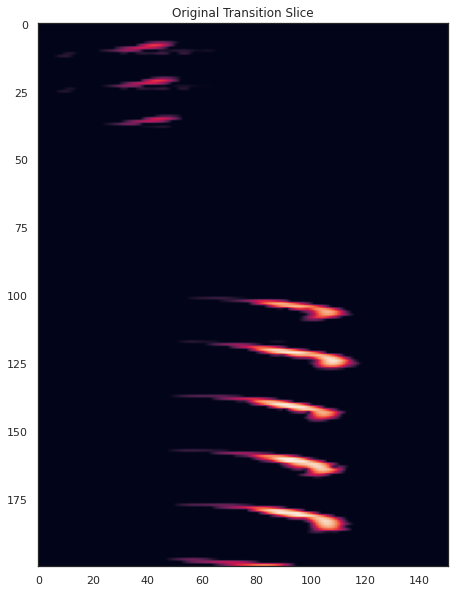

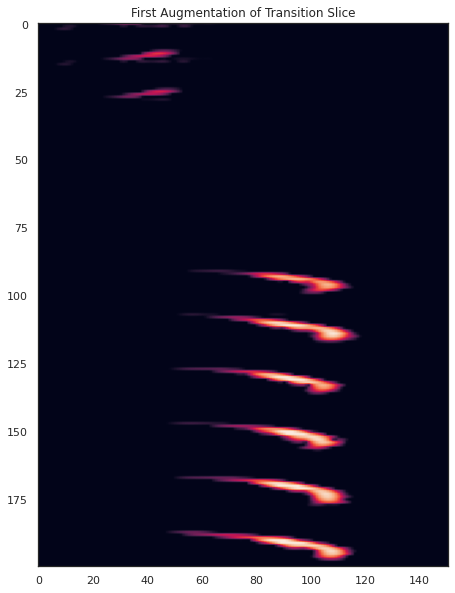

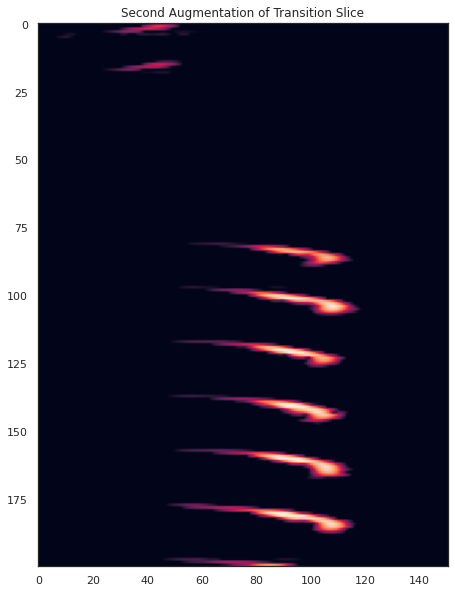

In [13]:
# Let's visualize the augmentations for the transition slices

# First go in the ground truth data and find the indices of the transition slices

unique_labels_per_spec = np.apply_along_axis(lambda x: len(np.unique(x)), 1, simple_tweetyclr.stacked_labels_train)

# train_unique_labels = unique_labels_per_spec[0:int(simple_tweetyclr.stacked_labels_for_window.shape[0]*0.8)]

train_transition_slices = np.where(unique_labels_per_spec>2)[0]

plt.figure()
plt.imshow(simple_tweetyclr.stacked_windows_train[train_transition_slices[0],:,:,:].clone().detach().numpy().squeeze())
plt.title("Original Transition Slice")
plt.show()

# First Augmentation

plt.figure()
plt.imshow(first_aug_tensor[train_transition_slices[0],:,:,:].clone().detach().numpy().squeeze())
plt.title("First Augmentation of Transition Slice")
plt.show()

plt.figure()
plt.imshow(second_aug_tensor[train_transition_slices[0],:,:,:].clone().detach().numpy().squeeze())
plt.title("Second Augmentation of Transition Slice")
plt.show()


In [14]:
train_transition_slices.shape[0]/unique_labels_per_spec.shape[0]

0.17617476033317617

In [15]:
# simple_tweetyclr.folder_name = simple_tweetyclr.folder_name[:-1]

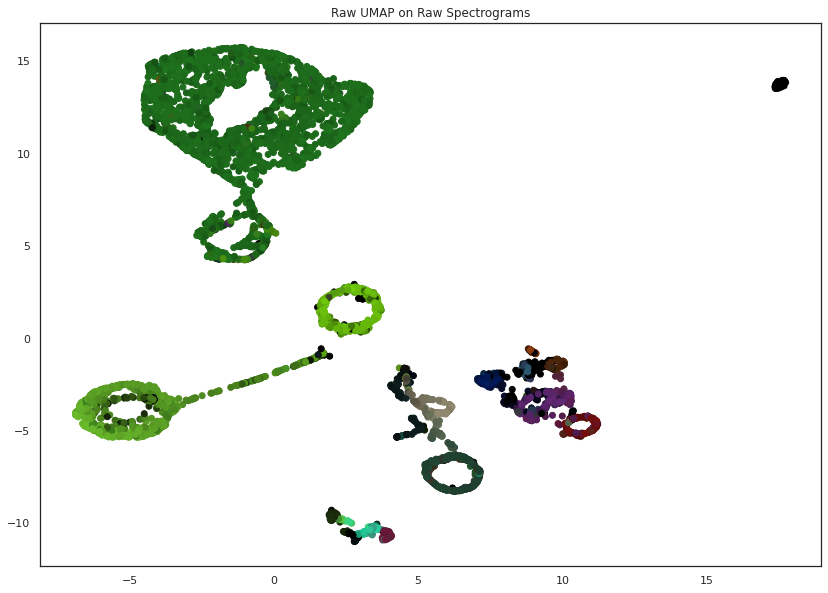

In [16]:
# Raw UMAP on the original spectrogram slices

reducer = umap.UMAP(metric = 'cosine')

a = first_aug_tensor.reshape(first_aug_tensor.shape[0], first_aug_tensor.shape[2]*first_aug_tensor.shape[3]).clone().detach().numpy()
embed = reducer.fit_transform(a)

plt.figure()
plt.title("Raw UMAP on Raw Spectrograms")
plt.scatter(embed[:,0], embed[:,1], c = simple_tweetyclr.mean_colors_per_minispec_train)
plt.savefig(f'{simple_tweetyclr.folder_name}/Plots/UMAP_of_raw_spectrograms.png')
plt.show()


In [17]:
simple_tweetyclr.raw_umap_embed = embed

In [18]:
# Model and dataloader parameters

from torch.utils.data import DataLoader

batch_size = 64  # or any other batch size you desire
first_aug_dataset = TensorDataset(first_aug_tensor, labels_tensor)
first_aug_dataloader = DataLoader(first_aug_dataset, batch_size=batch_size, shuffle=False)

second_aug_dataset = TensorDataset(second_aug_tensor, labels_tensor)
second_aug_dataloader = DataLoader(second_aug_dataset, batch_size=batch_size, shuffle=False)

# Part 1
model = TweetyNetCNN().to(torch.float32).to(device)
if torch.cuda.is_available():
    model = model.cuda()
    # criterion = criterion.cuda()   
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08)
# optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)  # Using weight decay with AdamW
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)

# criterion = SupConLoss(temperature=0.07)
method = 'SimCLR'
contrastive_loss, contrastive_lr = [], []
mean_cos_sim_epoch = []
mean_ntxent_sim_epoch = []
negative_similarities_mega = []
use_scheduler = True
use_scheduler_temp = False

if use_scheduler_temp:
    temp_value = 1.0
else:
    temp_value = simple_tweetyclr.temperature_value


# Temperature Scheduler
def exponential_decay(epoch, initial_value, decay_rate, decay_step):
    """
    Exponential decay for custom hyperparameter.

    Args:
        epoch (int): Current epoch number.
        initial_value (float): Initial value of the hyperparameter.
        decay_rate (float): Decay rate (usually between 0 and 1).
        decay_step (int): Interval of epochs after which decay is applied.

    Returns:
        float: Decayed value of the hyperparameter for the current epoch.
    """
    return initial_value * (decay_rate ** (epoch / decay_step))


initial_hyperparameter = 1.0  # Set this to your initial hyperparameter value
decay_rate = 0.97
decay_step = 1  # Apply decay every epoch, adjust as needed

temp_values = []
for epoch in range(num_epochs):
    # Get the decayed hyperparameter for this epoch
    decayed_hyperparameter = exponential_decay(epoch, initial_hyperparameter, decay_rate, decay_step)
    temp_values.append(decayed_hyperparameter)


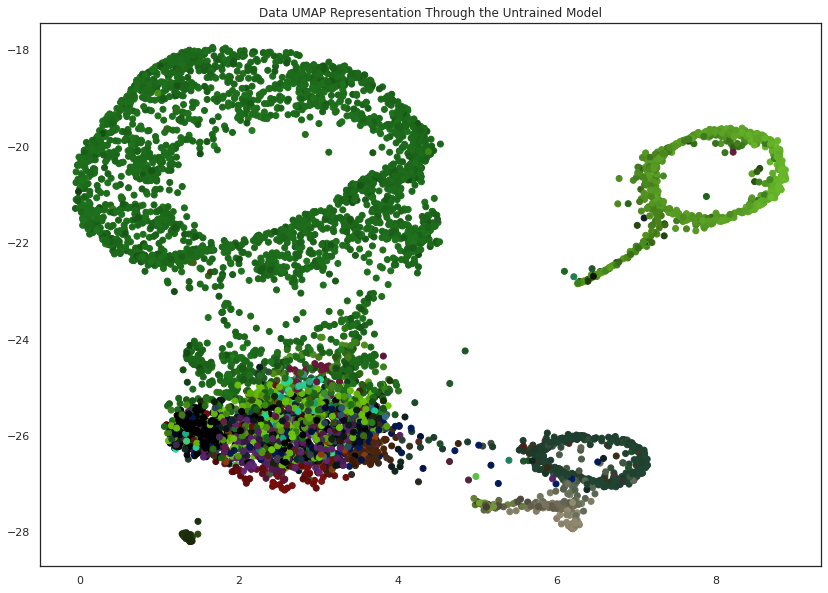

In [19]:
# In[8]: Pass data through untrained model and extract representation

# Untrained Model Representation

# Ensure the model is on the desired device
model = model.to('cpu')
model.eval()
# Initialize lists to store data and labels
model_rep_list_untrained = []
labels_list_untrained = []

# Iterate over the data
with torch.no_grad():  # Disable gradient computation for efficiency
    for batch_idx, ((data1, labels1), (data2, labels2)) in enumerate(zip(first_aug_dataloader, second_aug_dataloader)):
        # data = data[0]
        data = data1.to(torch.float32)
        features = model(data)
        model_rep_list_untrained.append(features)
        labels_list_untrained.append(labels1)

# Convert lists to tensors
model_rep_untrained = torch.cat(model_rep_list_untrained, dim=0)
labels_arr_untrained = torch.cat(labels_list_untrained, dim=0)

#  UMAP on the untrained model

reducer = umap.UMAP(metric = 'cosine')

a = model_rep_untrained.clone().detach().numpy()
embed = reducer.fit_transform(a)

plt.figure()
plt.title("Data UMAP Representation Through the Untrained Model")
plt.scatter(embed[:,0], embed[:,1], c = simple_tweetyclr.mean_colors_per_minispec_train)
plt.savefig(f'{simple_tweetyclr.folder_name}/Plots/UMAP_of_untrained_model.png')
plt.show()

In [20]:
simple_tweetyclr.untrained_model_umap_rep = embed

In [21]:
embed[:,0].shape

(6363,)

In [22]:
# Train the MOdel
num_epochs = 100
model = model.to('cuda')
model.train()
for epoch in range(1, num_epochs+1):
    criterion = SupConLoss(temperature=temp_value)
    loss, lr, negative_similarities_for_epoch, features, mean_pos_cos_sim_for_epoch, mean_ntxent_positive_similarities_for_epoch = pretraining(epoch, model, zip(first_aug_dataloader, second_aug_dataloader), optimizer, criterion, method=method)
    if use_scheduler:
        scheduler.step()
    if use_scheduler_temp:
        temp_value = exponential_decay(epoch, initial_hyperparameter, decay_rate, decay_step)
            
    contrastive_loss.append(loss)
    contrastive_lr.append(lr)
    
    # if epoch == 0:
    #     negative_similarities_mega.append(negative_similarities_for_epoch)
    # if epoch == num_epochs:
    #     negative_similarities_mega.append(negative_similarities_for_epoch)
        
    negative_similarities_mega.append(np.mean(negative_similarities_for_epoch))
    mean_cos_sim_epoch.append(np.mean(mean_pos_cos_sim_for_epoch))
    mean_ntxent_sim_epoch.append(np.mean(mean_ntxent_positive_similarities_for_epoch))


[Epoch: 001] Contrastive Pre-train | Loss: 0.6001 | Learning Rate: 0.0010
[Epoch: 002] Contrastive Pre-train | Loss: 0.1133 | Learning Rate: 0.0010
[Epoch: 003] Contrastive Pre-train | Loss: 0.0995 | Learning Rate: 0.0010
[Epoch: 004] Contrastive Pre-train | Loss: 0.0817 | Learning Rate: 0.0010
[Epoch: 005] Contrastive Pre-train | Loss: 0.0801 | Learning Rate: 0.0010
[Epoch: 006] Contrastive Pre-train | Loss: 0.0771 | Learning Rate: 0.0010
[Epoch: 007] Contrastive Pre-train | Loss: 0.1200 | Learning Rate: 0.0010
[Epoch: 008] Contrastive Pre-train | Loss: 0.0795 | Learning Rate: 0.0010
[Epoch: 009] Contrastive Pre-train | Loss: 0.0674 | Learning Rate: 0.0010
[Epoch: 010] Contrastive Pre-train | Loss: 0.0645 | Learning Rate: 0.0010
[Epoch: 011] Contrastive Pre-train | Loss: 0.0654 | Learning Rate: 0.0010
[Epoch: 012] Contrastive Pre-train | Loss: 0.0634 | Learning Rate: 0.0010
[Epoch: 013] Contrastive Pre-train | Loss: 0.0613 | Learning Rate: 0.0010
[Epoch: 014] Contrastive Pre-train | L

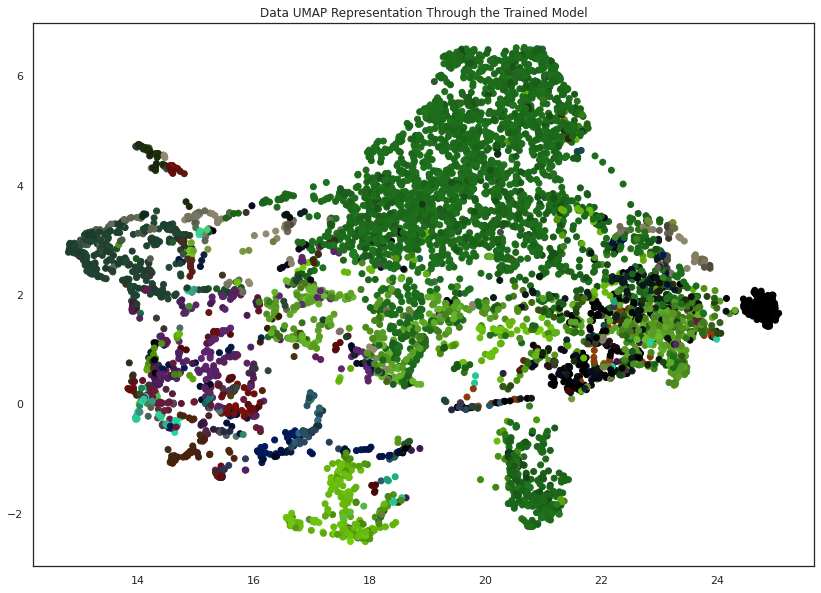

In [23]:
# In[10]: Extract the trained model representations

# Ensure the model is on the desired device
model = model.to('cpu')
model.eval()

# Initialize lists to store data and labels
model_rep_list_trained = []
labels_list_trained = []
# Iterate over the data
with torch.no_grad():  # Disable gradient computation for efficiency
    for batch_idx, ((data1, labels1), (data2, labels2)) in enumerate(zip(first_aug_dataloader, second_aug_dataloader)):
        # data = data[0]
        data = data1.to(torch.float32)
        features = model(data)
        model_rep_list_trained.append(features)
        labels_list_trained.append(labels1)

# Convert lists to tensors
model_rep_trained = torch.cat(model_rep_list_trained, dim=0)
labels_arr_trained = torch.cat(labels_list_trained, dim=0)

import umap
import numpy as np
reducer = umap.UMAP(metric='cosine')

# Compute the mean and standard deviation for each row
mean = model_rep_trained.mean(dim=1, keepdim=True)
std = model_rep_trained.std(dim=1, keepdim=True, unbiased=False)

# # Compute the z-score for each row
# z_scored_trained_rep = (model_rep_trained - mean) / std
# z_scored_trained_rep[torch.isnan(z_scored_trained_rep)] = 0
trained_rep_umap = reducer.fit_transform(model_rep_trained.clone().detach().numpy())

plt.figure()
plt.title("Data UMAP Representation Through the Trained Model")
plt.scatter(trained_rep_umap[:,0], trained_rep_umap[:,1], c = simple_tweetyclr.mean_colors_per_minispec_train)
plt.savefig(f'{simple_tweetyclr.folder_name}/UMAP_of_trained_model.png')
plt.show()


In [24]:
simple_tweetyclr.trained_rep_umap = trained_rep_umap

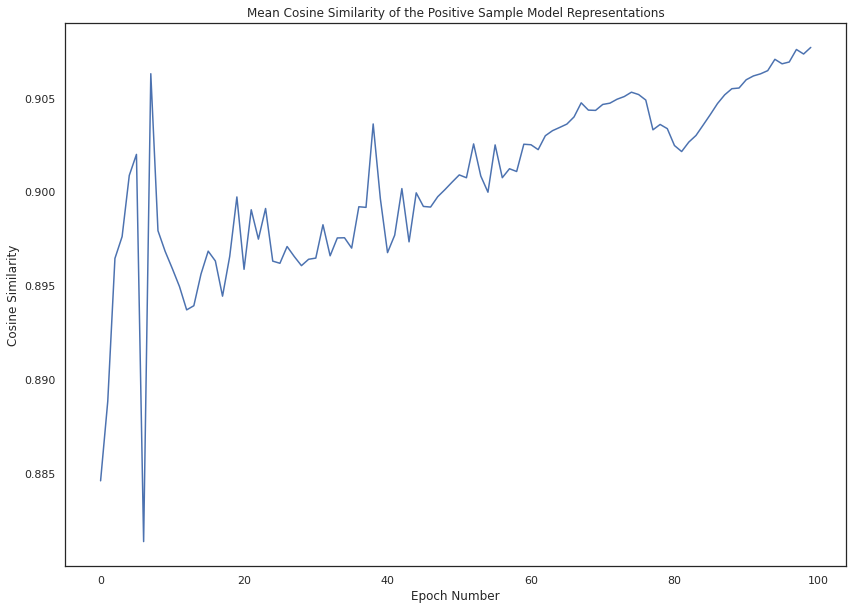

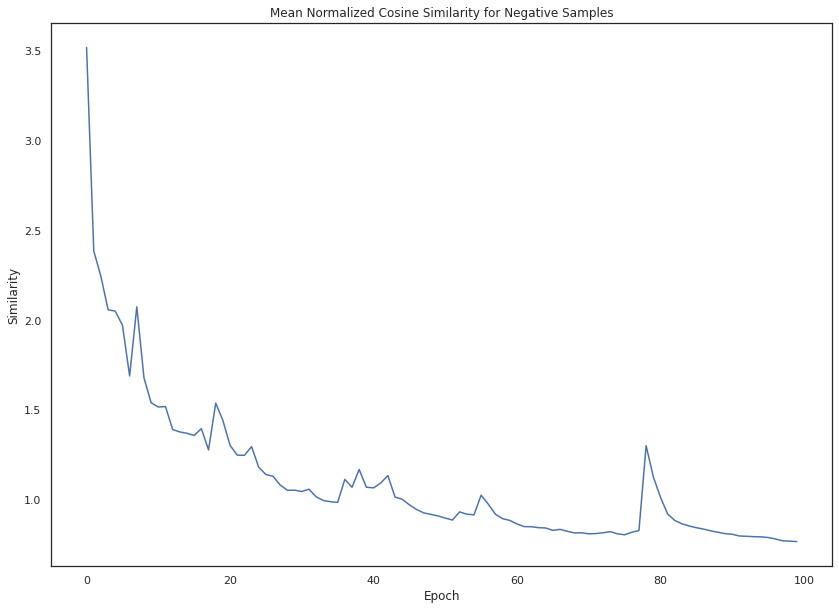

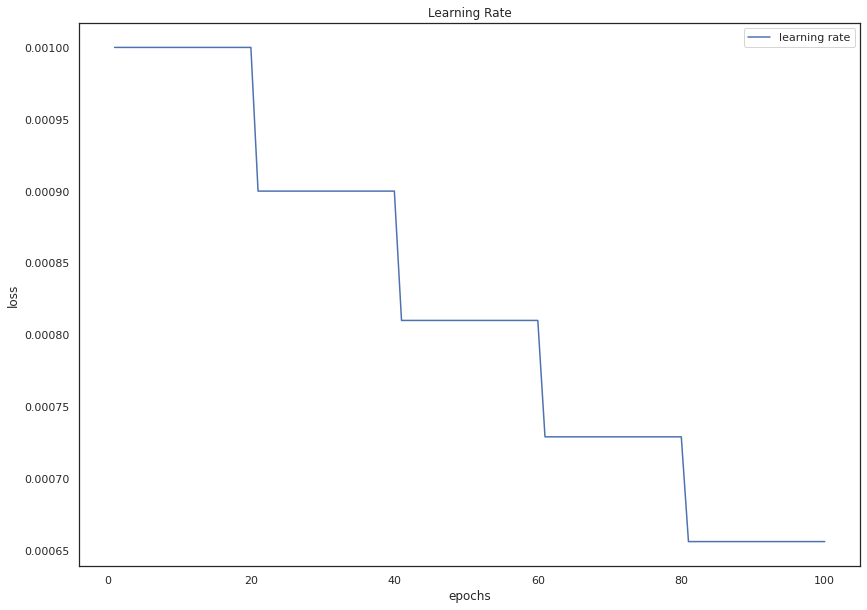

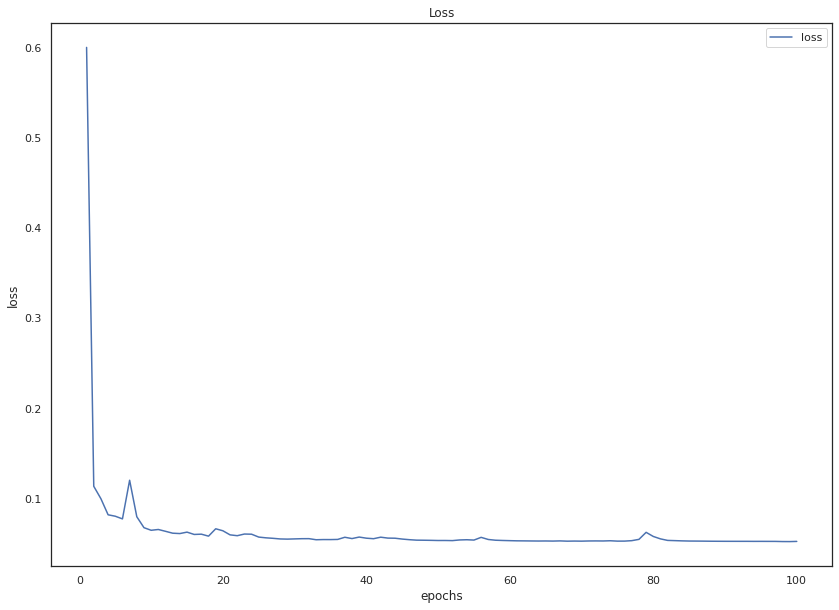

(<matplotlib.legend.Legend at 0x7fe8688faf50>,
 Text(20.200000000000003, 0.5, 'loss'),
 Text(0.5, 20.200000000000003, 'epochs'),
 Text(0.5, 1.0, 'Loss'),
 None,
 None)

In [25]:
# In[11]: Model Evaluation Metrics

# Positive Similarities
plt.figure()
plt.plot(mean_cos_sim_epoch)
plt.xlabel("Epoch Number")
plt.ylabel("Cosine Similarity")
plt.title("Mean Cosine Similarity of the Positive Sample Model Representations")
plt.savefig(f'{simple_tweetyclr.folder_name}/positive_similarities.png')
plt.show()

# Negative Similarities
plt.figure()
plt.plot(negative_similarities_mega)
plt.title('Mean Normalized Cosine Similarity for Negative Samples')
plt.xlabel('Epoch')
plt.ylabel('Similarity')
plt.savefig(f'{simple_tweetyclr.folder_name}/negative_similarities.png')
plt.show()

# Learning rate scheduler
plt.figure()
plt.plot(range(1,len(contrastive_lr)+1),contrastive_lr, color='b', label = 'learning rate')
plt.legend(), plt.ylabel('loss'), plt.xlabel('epochs'), plt.title('Learning Rate'), plt.savefig(f'{simple_tweetyclr.folder_name}/learning_rate.png'), plt.show()

# Contrastive Loss
plt.figure()
plt.plot(range(1,len(contrastive_loss)+1),contrastive_loss, color='b', label = 'loss')
plt.legend(), plt.ylabel('loss'), plt.xlabel('epochs'), plt.title('Loss'), plt.savefig(f'{simple_tweetyclr.folder_name}/contrastive_loss.png'), plt.show()

# unique_jawn = np.zeros((simple_tweetyclr.stacked_labels_train.shape[0],np.unique(simple_tweetyclr.stacked_labels_train).shape[0]))

# # for i in np.arange(simple_tweetyclr.stacked_labels_train.shape[0]):
# #     u, c = np.unique(simple_tweetyclr.stacked_labels_train[i,:], return_counts = True)



In [26]:
simple_tweetyclr.mean_cos_sim_epoch = mean_cos_sim_epoch
simple_tweetyclr.negative_similarities_mega = negative_similarities_mega
simple_tweetyclr.contrastive_loss = contrastive_loss

In [27]:
np.unique(simple_tweetyclr.stacked_labels_train).shape

(19,)

In [28]:
# Perform KMeans clustering
kmeans = KMeans(n_clusters=19)
kmeans.fit(trained_rep_umap)
predicted_labels = kmeans.labels_

# Calculate silhouette score
silhouette_avg = silhouette_score(trained_rep_umap, predicted_labels)
print(f"Silhouette Score: {silhouette_avg}")

simple_tweetyclr.silhouette_score = silhouette_avg

/home/akapoor/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.41195496916770935


In [29]:
with open(f'{simple_tweetyclr.folder_name}/simple_tweetyclr.pkl', "wb") as file:
    pickle.dump(simple_tweetyclr, file)